# Exemple supervisé avec transfer learning & data augmentation

Entraînement d'un modèle en utilisant uniquement le jeu de données supervisé.
Peut servir de point de départ à un premier essai pour la compétition.

In [1]:
!pip install skorch
!pip list

Package                           Version            
--------------------------------- -------------------
absl-py                           0.9.0              
affine                            2.3.0              
appdirs                           1.4.3              
attrs                             19.3.0             
backcall                          0.1.0              
bleach                            3.1.3              
cachetools                        4.0.0              
certifi                           2019.11.28         
chardet                           3.0.4              
click                             7.1.1              
click-plugins                     1.1.1              
cligj                             0.5.0              
cycler                            0.10.0             
decorator                         4.4.2              
defusedxml                        0.6.0              
entrypoints                       0.3                
Fiona                       

In [2]:
!ls /kaggle/input/isae-ssl-hackathon-2020/

ls: cannot access '/kaggle/input/isae-ssl-hackathon-2020/': No such file or directory


In [3]:
import os
import random
import datetime

import matplotlib.cm
import numpy as np

In [4]:
import pandas as pd
import scipy
import skimage.exposure
import sklearn
import sklearn.metrics
import sklearn.metrics
import sklearn.preprocessing
import skorch.helper
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torchvision
import tqdm
from matplotlib import pyplot as plt

/home/fchouteau/miniconda3/envs/py37-isae/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
random.seed(2020)
np.random.seed(2020)
torch.manual_seed(2020)

In [6]:
TRAIN_DATA_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/hackathon-2020/eurosat_train.npz"

VALID_DATA_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/hackathon-2020/eurosat_valid.npz"

KAGGL_DATA_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/hackathon-2020/test.npz"

CLASSES = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
    'River', 'SeaLake'
]

DATASOURCE = np.DataSource(None)

In [7]:
def plot_imgs(x, y=None, grid_size=4, title="samples"):
    """
    Plot grid_size*grid_size images
    """
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
    fig.tight_layout()
    idxs = np.random.randint(len(x), size=16)

    for i in range(grid_size**2):
        k = idxs[i]
        if y is not None:
            img, lbl = x[k], CLASSES[y[k]]
        else:
            img, lbl = x[k], "unlabelled"
        if img.dtype == np.float32:
            img = skimage.exposure.rescale_intensity(img, out_range=(0., 1.))
        img = skimage.exposure.adjust_gamma(img, gamma=0.7)
        ax[i % 4][i // 4].imshow(img)
        ax[i % 4][i // 4].set_title(lbl)
        ax[i % 4][i // 4].axis('off')
    fig.suptitle(title, fontsize=14)
    plt.show()

## Datasets

In [8]:
train_dataset = DATASOURCE.open(TRAIN_DATA_URL, "rb")
train_dataset = np.load(train_dataset)

valid_dataset = DATASOURCE.open(VALID_DATA_URL, "rb")
valid_dataset = np.load(valid_dataset)

In [9]:
x_train, y_train = train_dataset['x'], train_dataset['y']
x_valid, y_valid = valid_dataset['x'], valid_dataset['y']

In [10]:
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(500, 64, 64, 3) (500,)
(1500, 64, 64, 3) (1500,)


In [11]:
class ArrayDataset(torch.utils.data.Dataset):
    def __init__(self, array_x, array_y, transform=None):
        self.array_x = array_x
        self.array_y = array_y
        self.transform = transform

    def __len__(self):
        return self.array_x.shape[0]

    def __getitem__(self, idx):
        x = self.array_x[idx]
        y = self.array_y[idx]
        if self.transform is not None:
            x = self.transform(x)
        else:
            x = torch.tensor(x)
        y = torch.tensor(y)
        return x, y

In [12]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(
        brightness=0.25,
        contrast=0.25,
        saturation=0.25,
        hue=0.1,
    ),
    torchvision.transforms.ToTensor(),
])

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [13]:
train_ds = ArrayDataset(x_train, y_train, transform=train_transforms)
valid_ds = ArrayDataset(x_valid, y_valid, transform=valid_transforms)

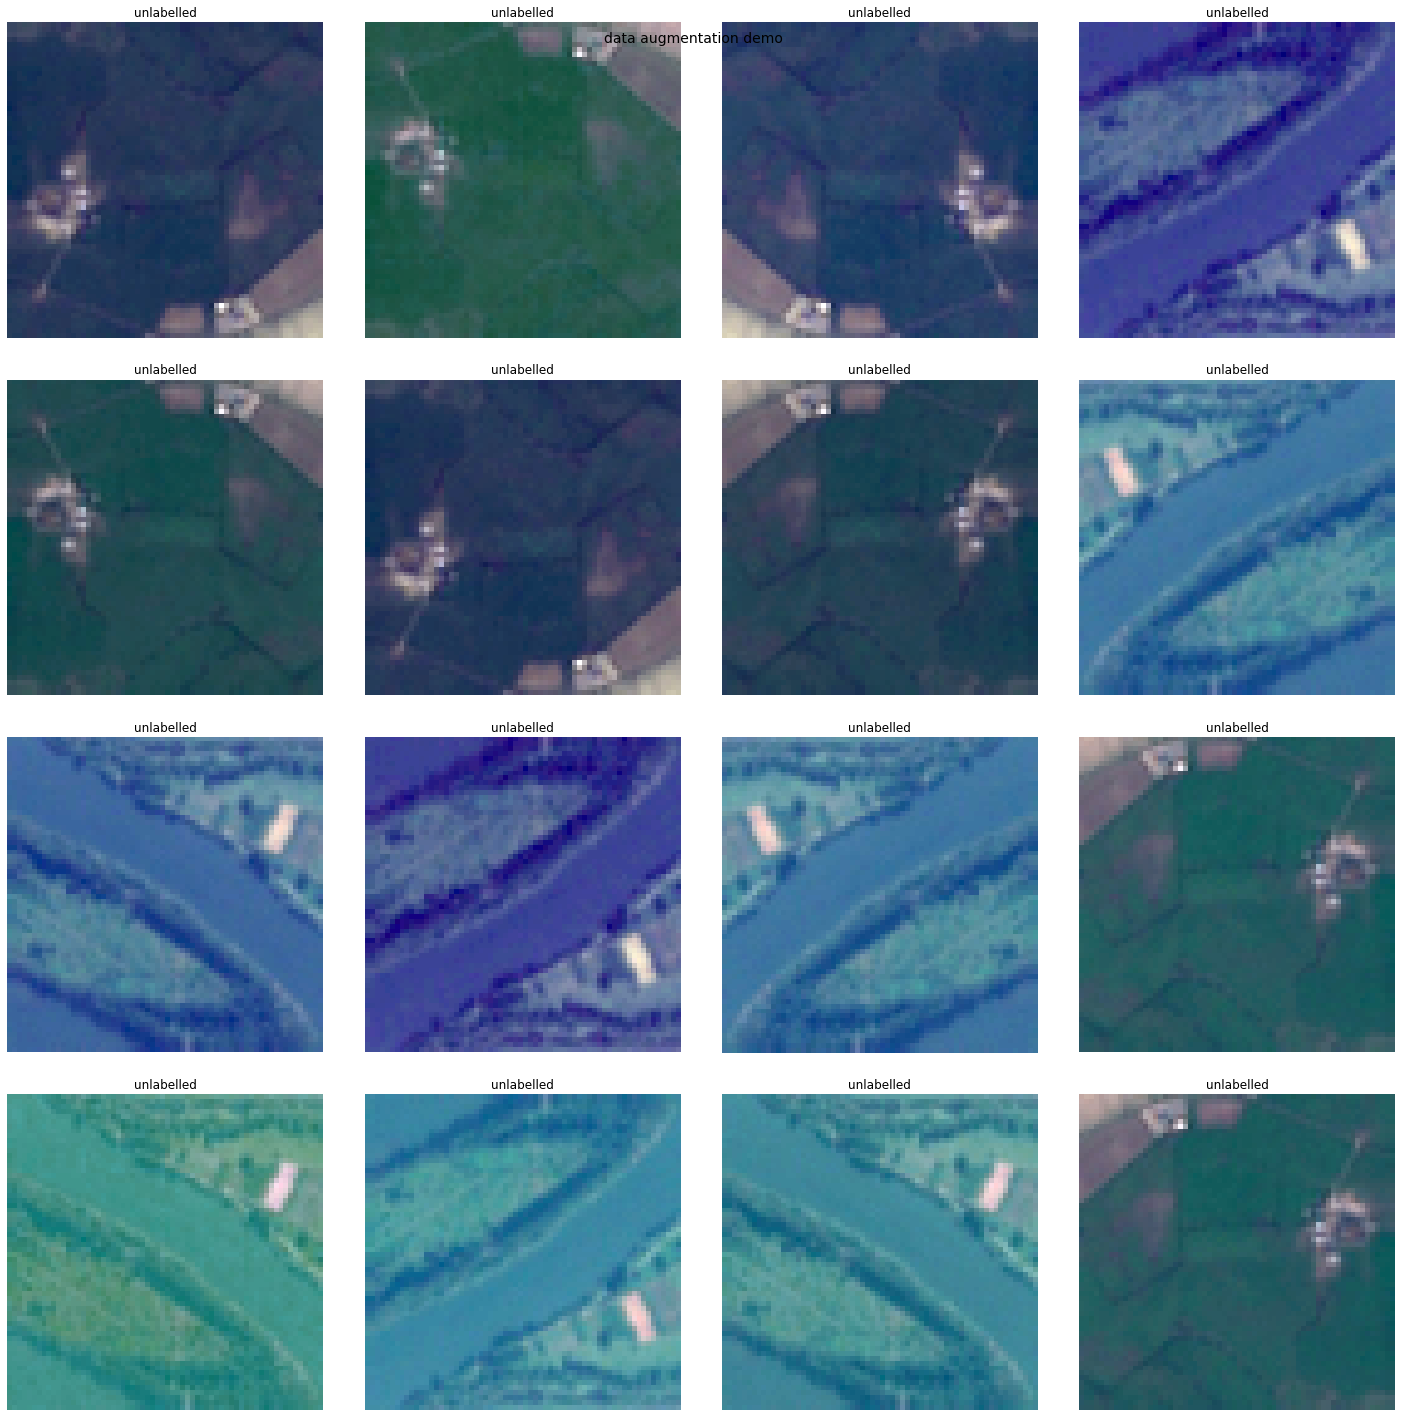

In [14]:
examples = np.asarray([train_ds[np.random.randint(0, 2)][0].numpy() for _ in range(16)])
examples = np.transpose(examples, (0, 2, 3, 1))
plot_imgs(examples, y=None, title="data augmentation demo")

In [15]:
# Helper in skorch to use a custom validation dataset instead of splitting the train set
# https://skorch.readthedocs.io/en/stable/user/FAQ.html#i-already-split-my-data-into-training-and-validation-sets-how-can-i-use-them

train_split = skorch.helper.predefined_split(valid_ds)

## Model

In [16]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
        m.bias.data.fill_(0.1)
    if type(m) == nn.Linear:
        # apply a uniform distribution to the weights and a bias=0
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
        m.bias.data.fill_(0.1)


def init_weights_tl(m):
    # if type(m) == nn.Conv2d:
    #     torch.nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
    #     m.bias.data.fill_(0.1)
    if type(m) == nn.Linear:
        # apply a uniform distribution to the weights and a bias=0
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
        m.bias.data.fill_(0.1)

In [17]:
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = torchvision.models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, output_features),
            nn.Softmax(dim=1),
        )

        self.model = model

    def forward(self, x):
        return self.model(x)


model = PretrainedModel(output_features=10)

In [18]:
model.apply(init_weights_tl)

PretrainedModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## Training

In [19]:
# Freeze model
freezer = skorch.callbacks.Freezer(lambda x: not x.startswith('model.fc'))

lr_scheduler = skorch.callbacks.LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                            factor=0.1,
                                            patience=3,
                                            monitor='valid_loss')

early_stopping = skorch.callbacks.EarlyStopping(patience=5)

checkpoint_dir = './tmp'
os.makedirs(checkpoint_dir, exist_ok=True)

# Checkpoint
cp = skorch.callbacks.Checkpoint(dirname=checkpoint_dir)
# Restore best checkpoint at end of training
train_end_cp = skorch.callbacks.TrainEndCheckpoint(dirname=checkpoint_dir)

lr = 0.01
batch_size = 32
max_epochs = 20

net = skorch.NeuralNetClassifier(
    model,
    batch_size=batch_size,
    max_epochs=max_epochs,
    lr=lr,
    train_split=train_split,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device="cuda" if torch.cuda.is_available() else "cpu",
    # skorch automatically applies logarithm so we have softmax at the end of our model
    criterion=nn.modules.loss.NLLLoss,
    optimizer=optim.Adam,
    callbacks=[freezer, lr_scheduler, early_stopping, cp, train_end_cp])

In [20]:
net.fit(train_ds, y=None)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        5.3540       0.3993        1.9728     +  7.4687
      2        1.6627       0.5813        1.3469     +  7.9753
      3        1.3611       0.6640        1.0229     +  7.5855
      4        1.3131       0.6907        0.9948     +  7.4844
      5        1.1584       0.6733        1.0341        6.8382
      6        1.1194       0.6893        0.9631     +  7.4738
      7        1.0969       0.6807        0.9547     +  7.7350
      8        1.1083       0.6773        0.9925        8.2556
      9        1.0543       0.7033        0.9436     +  7.1933
     10        1.0538       0.6987        0.9722        8.1112
     11        0.9687       0.7147        0.9282     +  7.5236
     12        1.0125       0.7247        0.8707     +  6.9834
     13        0.9950       0.7093        0.9012        7.5339
     14        0.9984       0.6927        0.9858       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PretrainedModel(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

## Metrics on validation dataset

In [21]:
x_val = np.copy(x_valid)
x_val = x_val.astype(np.float32) / 255.
x_val = np.transpose(x_val, (0, 3, 1, 2))

In [22]:
x_val.shape, x_val.dtype

((1500, 3, 64, 64), dtype('float32'))

In [23]:
y_pred = net.predict(x_val)
print(sklearn.metrics.classification_report(y_valid, y_pred, digits=2))
acc = sklearn.metrics.accuracy_score(y_valid, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       150
           1       0.97      0.62      0.76       150
           2       0.65      0.67      0.66       150
           3       0.55      0.58      0.56       150
           4       0.84      0.81      0.82       150
           5       0.57      0.83      0.68       150
           6       0.51      0.56      0.53       150
           7       0.77      0.89      0.82       150
           8       0.77      0.45      0.57       150
           9       0.95      0.83      0.89       150

    accuracy                           0.71      1500
   macro avg       0.73      0.71      0.71      1500
weighted avg       0.73      0.71      0.71      1500



In [24]:
y_pred_proba = net.predict_proba(x_val)

In [25]:
y_valid_onehot = sklearn.preprocessing.label_binarize(y_valid, range(10))

In [26]:
# Compute ROC curve and ROC area for each class
def plot_roc_curve(y_test, y_pred, classes):
    n_classes = len(classes)

    fpr = dict()
    tpr = dict()
    f1 = dict()
    prc = dict()
    rcc = dict()
    thr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_pred[:, i])
        prc[i], rcc[i], thr[i] = sklearn.metrics.precision_recall_curve(y_test[:, i], y_pred[:, i])
        f1[i] = 2 * prc[i] * rcc[i] / (prc[i] + rcc[i])
        max_f1 = np.max(f1[i])
        prc_maxf1 = prc[i][np.argmax(f1[i])]
        rcc_maxf1 = rcc[i][np.argmax(f1[i])]
        thr_maxf1 = thr[i][np.argmax(f1[i])]
        print("Class {: >24}, max F1: {:.02}, P {:.02f}, R {:.02f}, threshold: {:.02f}".format(
            classes[i], max_f1, prc_maxf1, rcc_maxf1, rcc_maxf1, thr_maxf1))
        roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += scipy.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = sklearn.metrics.auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    #     colors = itertools.cycle(['aqua', 'coral', 'gold', 'ivory', 'green', 'blue', 'cyan'])
    colors = matplotlib.cm.get_cmap('Pastel1')
    colors = colors(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

Class               AnnualCrop, max F1: 0.82, P 0.81, R 0.82, threshold: 0.82
Class                   Forest, max F1: 0.84, P 0.83, R 0.84, threshold: 0.84
Class     HerbaceousVegetation, max F1: 0.69, P 0.65, R 0.75, threshold: 0.75
Class                  Highway, max F1: 0.59, P 0.60, R 0.57, threshold: 0.57
Class               Industrial, max F1: 0.83, P 0.84, R 0.82, threshold: 0.82
Class                  Pasture, max F1: 0.74, P 0.78, R 0.70, threshold: 0.70
Class            PermanentCrop, max F1: 0.57, P 0.65, R 0.51, threshold: 0.51
Class              Residential, max F1: 0.86, P 0.82, R 0.90, threshold: 0.90
Class                    River, max F1: 0.62, P 0.72, R 0.55, threshold: 0.55
Class                  SeaLake, max F1: 0.89, P 0.96, R 0.83, threshold: 0.83


/home/fchouteau/miniconda3/envs/py37-isae/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


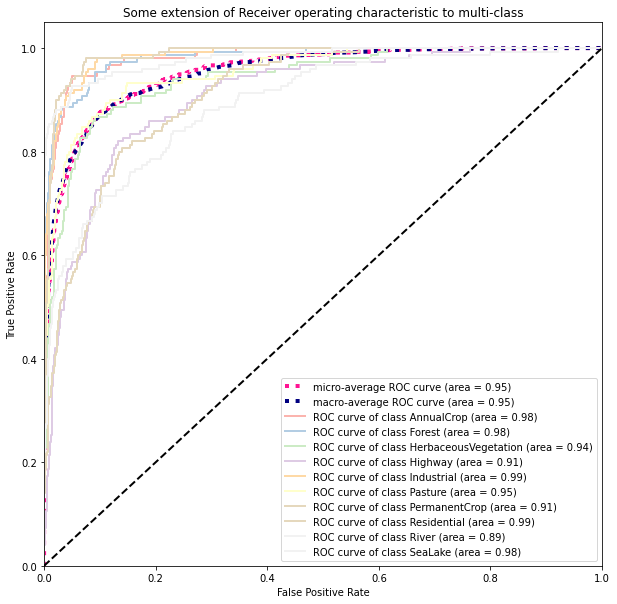

In [27]:
plot_roc_curve(y_valid_onehot, y_pred_proba, CLASSES)

## Model saving

In [28]:
model = net.module
xp_id = datetime.datetime.now().strftime("%Y%m%d_%H%M")
torch.save(model, "./model_{}.pt".format(xp_id))

/home/fchouteau/miniconda3/envs/py37-isae/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type PretrainedModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Predictions & submission

In [29]:
test_dataset = DATASOURCE.open(KAGGL_DATA_URL, 'rb')
test_dataset = np.load(test_dataset)
x_test = test_dataset['x']

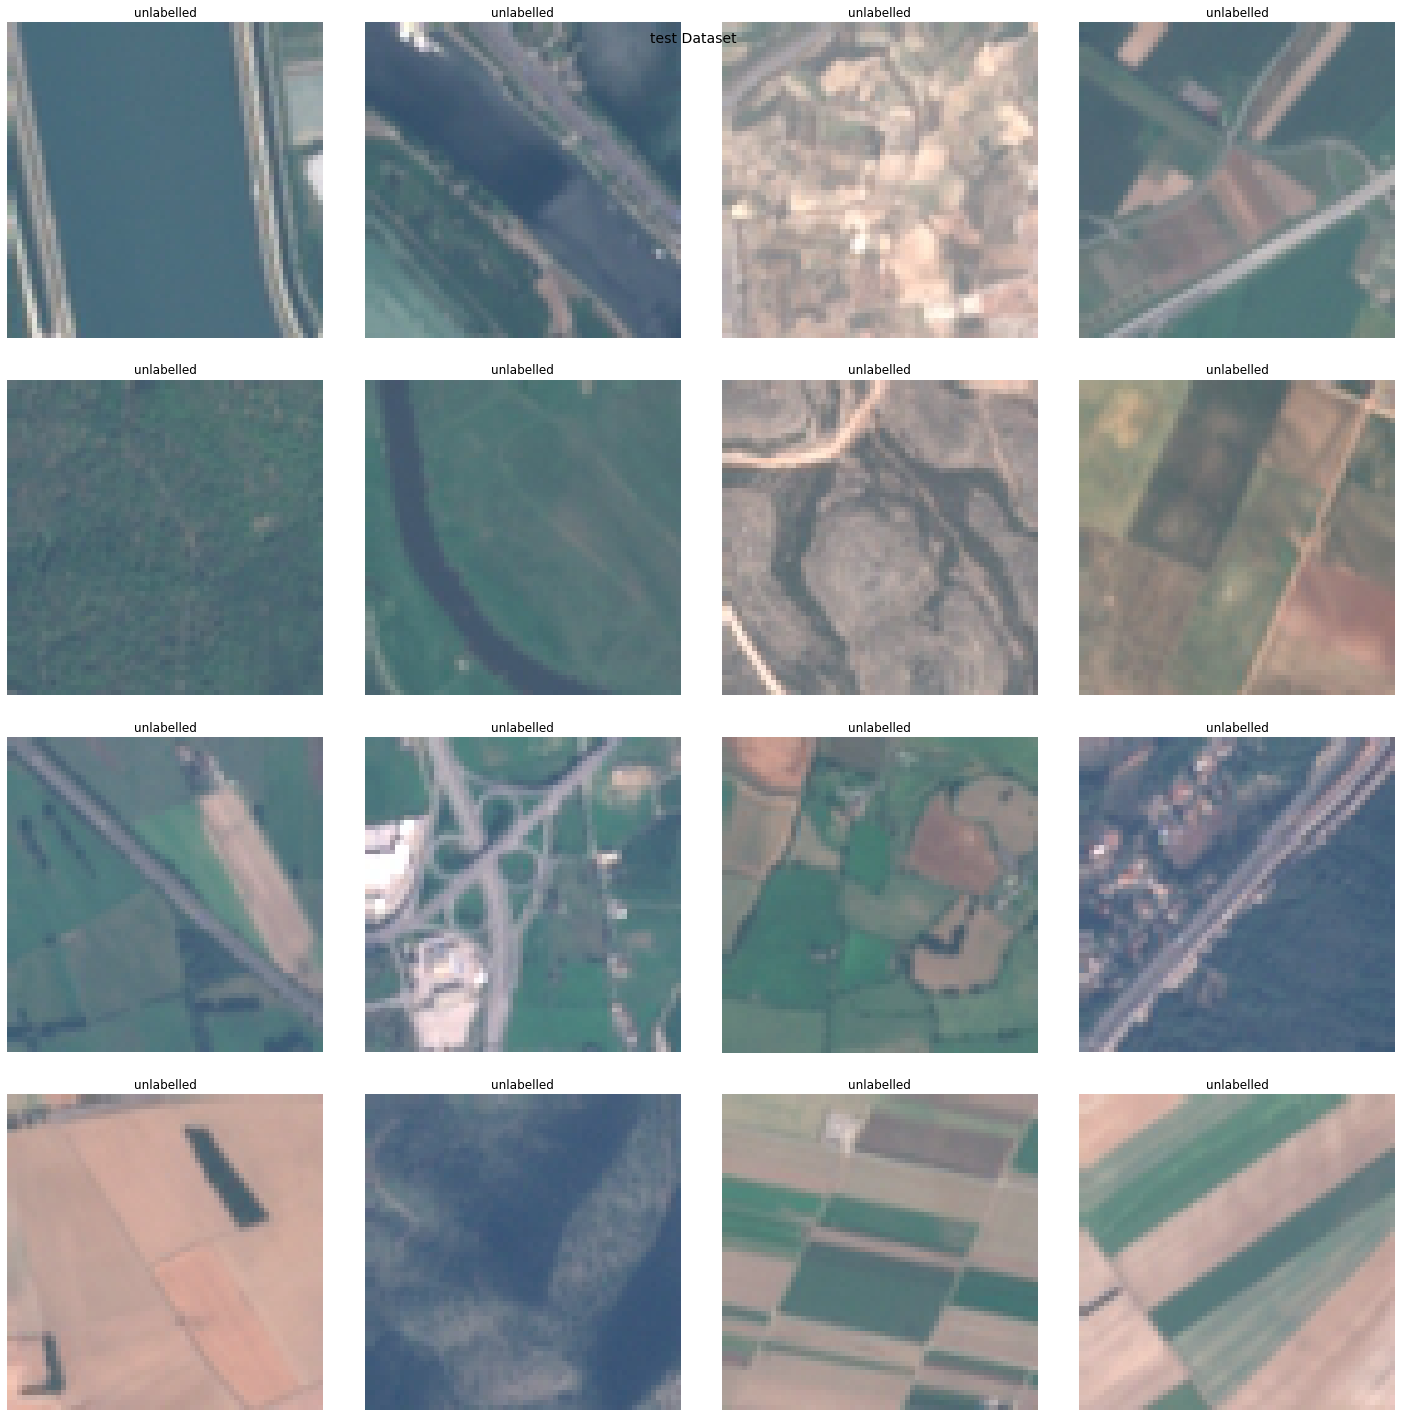

In [30]:
plot_imgs(x_test, y=None, title="test Dataset")

In [31]:
model_predict = torch.load("./model_{}.pt".format(xp_id))

In [32]:
def predict(image):
    """
    Fonction de prédiction qui renvoie la classe (index) prédite par le modèle
    """

    # preprocessing sur l'image
    x = image.astype(np.float32) / 255.
    x = np.transpose(x, (2, 0, 1))
    x = x[None, :, :]
    x = torch.tensor(x)

    # prédiction (index !)
    y_pred = model_predict(x)
    y_pred = y_pred.detach().numpy()

    y_pred = np.argmax(y_pred)
    return y_pred


def make_submission(predictions):
    """
    Génère un dataframe de soumission pour la compétition
    predictions est une liste de couples (idx, class_index)
    Exemple [(0,1),(1,9),(2,4)]"""
    df = []
    for idx, y_pred in predictions:
        cls_str = CLASSES[y_pred]
        df.append({"Id": idx, "Category": cls_str})
    df = sorted(df, key=lambda x: x["Id"])
    df = pd.DataFrame(df)
    return df

In [33]:
predictions = []

for idx, img in enumerate(tqdm.tqdm(x_test)):
    y_pred = predict(img)
    predictions.append((idx, y_pred))

submission_csv = make_submission(predictions)

100%|██████████| 20000/20000 [04:55<00:00, 67.60it/s]


In [34]:
sub_id = "submission_{}.csv".format(xp_id)
# Sauvegarde du dataframe en csv. ATTENTION: index=False sinon BUG !
submission_csv.to_csv('./{}.csv'.format(sub_id), index=False)